In [1]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset
import torch.nn as nn
import torch.optim as optim

In [2]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
image_datasets = {x: PapilledemaDataset(data_dir=data_dir, phase=x) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1', '2', '3', '4', '5']


In [3]:
bestsmodel = SeverityModel().to(device)
state_dict = torch.load('./pretrained/best-smodel50-wofreeze-2024-03-10.pt')
bestsmodel.load_state_dict(state_dict)

load simclr resnet


<All keys matched successfully>

In [4]:
bestsmodel.bestsimese50simclr.cnn1.fc = torch.nn.Sequential(*(list(bestsmodel.bestsimese50simclr.cnn1.fc)+list(bestsmodel.bestsimese50simclr.cnn1.fc2)))

In [5]:
torch.save(bestsmodel.bestsimese50simclr.cnn1.state_dict(), './pretrained/COPE-resnet50.pt')

In [9]:
clf_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
clf_model.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                # torch.nn.Linear(256, 256),
                                # torch.nn.ReLU(),
                                # torch.nn.Dropout(0.1),
                                # torch.nn.Linear(256, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, len(class_names)))
clf_model.load_state_dict(torch.load('./pretrained/COPE-resnet50.pt'), strict=False)


_IncompatibleKeys(missing_keys=['fc.6.weight', 'fc.6.bias'], unexpected_keys=['fc2.0.weight', 'fc2.0.bias', 'fc2.3.weight', 'fc2.3.bias', 'fc.7.weight', 'fc.7.bias', 'fc.4.weight', 'fc.4.bias'])

In [10]:
clf_model = clf_model.to(device)
momentum = 0.9
lr = 0.01
optimizer_ft = optim.SGD([{'params': clf_model.fc[:].parameters()}], lr=lr, momentum=momentum)
class_weights=torch.tensor([0.3, 1.28, 1.51, 1.31, 3.18, 11],dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in clf_model.parameters():
    param.requires_grad = False
for param in clf_model.fc[:].parameters():
    param.requires_grad = True
# for param in clf_model.fc[8:].parameters():
#     param.requires_grad = True
# for param in clf_model.fc.parameters():
#         param.requires_grad = True

In [11]:
# bestmodel = siamese50simclr
valaccmax = 0
for e in range(50):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0

    for inputs, labels in dataloaders['train']:
        clf_model.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        outputs = clf_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item() * inputs.size(0)
        training_acc += torch.sum(preds == labels.data)

    for inputs, labels in dataloaders['val']:
        clf_model.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = clf_model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)

        val_acc += torch.sum(preds == labels.data)

    if(e > 5 and val_acc > valaccmax):
        valaccmax = val_acc
        torch.save(clf_model.state_dict(), './pretrained/best-mutlclassclassification-siamese50COPE.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", training_acc.detach().cpu().numpy() / dataset_sizes['train'], "Val acc: ", val_acc.detach().cpu().numpy() / dataset_sizes['val'], "traning loss: ", training_loss_test / dataset_sizes['train'])

E0 With LR 0.01 training acc:  0.15201192250372578 Val acc:  0.4823529411764706 traning loss:  1.75893988143847
E1 With LR 0.01 training acc:  0.518628912071535 Val acc:  0.6235294117647059 traning loss:  1.6051278446541457
E2 With LR 0.01 training acc:  0.4247391952309985 Val acc:  0.4470588235294118 traning loss:  1.4595635491582923
E3 With LR 0.01 training acc:  0.3472429210134128 Val acc:  0.24705882352941178 traning loss:  1.427533853427131
E4 With LR 0.01 training acc:  0.3323397913561848 Val acc:  0.5882352941176471 traning loss:  1.4427800109240763
E5 With LR 0.01 training acc:  0.46348733233979134 Val acc:  0.17647058823529413 traning loss:  1.3594312936111996
E6 With LR 0.01 training acc:  0.4396423248882265 Val acc:  0.47058823529411764 traning loss:  1.317581879222091
E7 With LR 0.01 training acc:  0.5081967213114754 Val acc:  0.2 traning loss:  1.2690132579220745
E8 With LR 0.01 training acc:  0.5350223546944859 Val acc:  0.25882352941176473 traning loss:  1.21742076614396

KeyboardInterrupt: 

In [12]:
bestmodel = get_feature_extractor(feature_extractor='resnet50', cotrain=False)#, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')

bestmodel.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                # torch.nn.Linear(256, 256),
                                # torch.nn.ReLU(),
                                # torch.nn.Dropout(0.1),
                                # torch.nn.Linear(256, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, len(class_names)))
bestmodel.load_state_dict(torch.load('./pretrained/best-mutlclassclassification-siamese50COPE.pt'))
bestmodel.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
test_acc = 0
predlist = []
labelist = []
problist = []
test_embeddings = torch.zeros((0, 2048))
sedis = 0
fextractor = torch.nn.Sequential(*(list(clf_model.children())[:-1]))

for inputs, labels in dataloaders['test']:
    clf_model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = clf_model(inputs)
        emb = fextractor(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        sedis = sedis + torch.sum(torch.exp(torch.abs(labels - torch.max(outputs, 1)[1])))
    problist.append(outputs[:,1].detach().cpu().numpy())
    labelist.append(labels.detach().cpu().numpy()*1)
    predlist.append(preds.detach().cpu().numpy())
    # test_embeddings  = torch.cat((test_embeddings, emb.detach().cpu().flatten().unsqueeze(0)), axis=0)
    test_acc += torch.sum(preds == labels.data)

labelist = np.concatenate(labelist).ravel()
problist = np.concatenate(problist).ravel()
predlist = np.concatenate(predlist).ravel()
# test_embeddings = np.array(test_embeddings)

In [14]:
sedis/dataset_sizes['test']

tensor(4.8233, device='cuda:0')

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(classification_report(labelist, predlist, digits=3))

              precision    recall  f1-score   support

           0      0.683     0.560     0.615        50
           1      0.250     0.444     0.320         9
           2      0.308     0.333     0.320        12
           3      0.429     0.462     0.444        13
           4      0.571     0.667     0.615         6
           5      1.000     0.667     0.800         3

    accuracy                          0.516        93
   macro avg      0.540     0.522     0.519        93
weighted avg      0.560     0.516     0.531        93



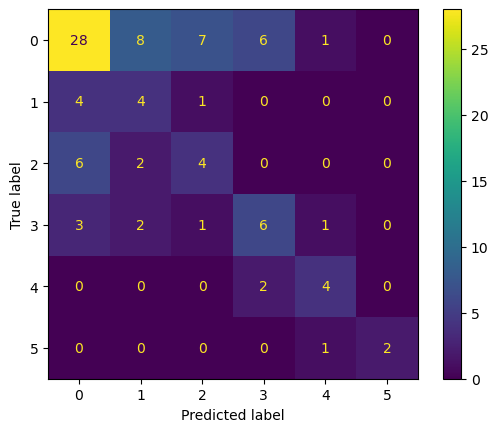

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labelist, predlist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [14]:
import sklearn.metrics as metrics

y_test = (labelist)
y_pred =(problist)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
plt.grid(linestyle='--')
roc_auc_score(y_test, y_pred)

ValueError: multiclass format is not supported